In [1]:
import numpy as np

In [35]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt


specgram_folder = Path('/Users/eric/Engineering/Work/pisces/data_sets/specgrams')

specgram_data = defaultdict(dict)

for subdir in ['pisces', 'NSR']:
    for file in specgram_folder.joinpath(subdir).glob('*.npy'):
        subject_id = file.stem.split('_')[0]
        if subject_id == "hybrid":
            continue
        specgram_data[subject_id][subdir] = np.load(file)

In [16]:
specgram_data.keys()

dict_keys(['781756', '1066528', '5498603', '4426783', '8000685', '1818471', '3509524', '8686948', '9618981', '844359', '2638030', '8692923', '1455390', '1449548', '9961348', '5132496', '4018081', '3997827', '4314139', '2598705', '9106476', '1360686', '5797046', '759667', '46343', '8173033', '8530312', '6220552', '5383425', '8258170'])

In [31]:
pspecs = []
nspecs = []
for key in specgram_data.keys():
    try:
        pspecs.append(specgram_data[key]['pisces'])
        nspecs.append(specgram_data[key]['NSR'][..., 0])
    except KeyError as ke:
        print(f"KeyError: {ke}")
        print(f"Key: {key}")
        continue

pspecs = np.array(pspecs)
nspecs = np.array(nspecs)

KeyError: 'pisces'
Key: 5383425
KeyError: 'pisces'
Key: 8258170


In [33]:
pspecs.shape

(28, 15360, 32)

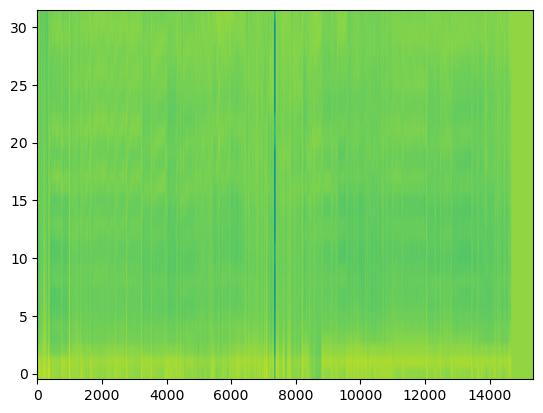

In [34]:
plt.imshow(pspecs[0].T, aspect='auto', origin='lower')

Text(0.5, 0, 'Difference (dB)')

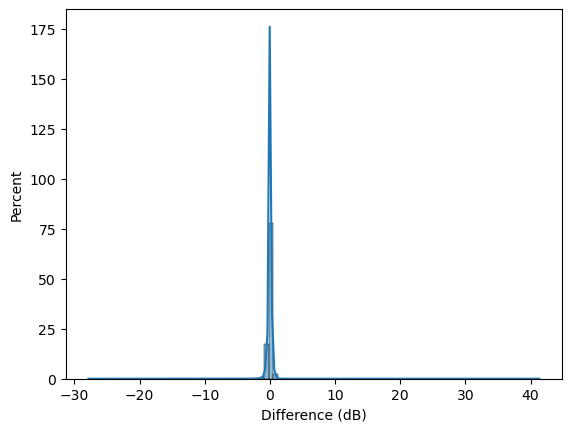

In [37]:
import seaborn as sns
sns.histplot((pspecs - nspecs).ravel(), bins=100, stat='percent', kde=True)
plt.xlabel('Difference (dB)')